## Import libraries


In [1]:
import os
import sys
import time

source_folder = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src"
sys.path.append(source_folder)

import os
import pickle
from collections import defaultdict

import config.winter_wheat as cfg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from config.winter_wheat import model_config, train_config
from dataset.dataset import CropFusionNetDataset
from loss.loss import QuantileLoss
from models.CropFusionNet.model import CropFusionNet
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from utils.utils import set_seed, evaluate_and_save_outputs, save_config, load_config

crop = "winter_barley"
cfg, model_config, train_config = load_config(crop)

device = model_config["device"]
set_seed(42)

checkpoint_dir = r"/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src/train/checkpoints"

## Create datasets and dataloader


In [2]:
train_dataset = CropFusionNetDataset(cfg, mode="train", scale=True)
val_dataset = CropFusionNetDataset(cfg, mode="val", scale=True)
test_dataset = CropFusionNetDataset(cfg, mode="test", scale=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_config["batch_size"],
    shuffle=True,
    num_workers=32,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_config["batch_size"],
    shuffle=False,
    num_workers=32,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_config["batch_size"],
    shuffle=False,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

## Load the best model


In [3]:
model = CropFusionNet(model_config).to(device)
checkpoint_path = os.path.join(
    "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src/train/forecast/winter_barley/Jul/best_model.pt"
)
assert os.path.exists(checkpoint_path), f"❌ No checkpoint found at {checkpoint_path}"
model.load_state_dict(
    torch.load(checkpoint_path, map_location=device, weights_only=True)
)
model.eval()
print(f"✅ Loaded pretrained model from {checkpoint_path}")
criterion = QuantileLoss(quantiles=model_config["quantiles"]).to(device)

✅ Loaded pretrained model from /beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src/train/forecast/winter_barley/Jul/best_model.pt


## Run inference


In [4]:
def run_inference(
    model, test_loader, device, criterion=None, output_path="inference_results.pkl"
):
    """
    Runs inference on CropFusionNet, capturing predictions, targets, and attention weights.
    """
    model.eval()

    # Storage for all batches
    results_buffer = defaultdict(list)

    print(f"🚀 Starting inference on {device}...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Inference"):

            # 1. Prepare Inputs
            inputs = {
                "inputs": batch["inputs"].to(device),
                "identifier": batch["identifier"].to(device),
                "mask": batch["mask"].to(device),
                "variable_mask": (
                    batch.get("variable_mask").to(device)
                    if batch.get("variable_mask") is not None
                    else None
                ),
            }
            targets = batch["target"].to(device)

            # 2. Forward Pass
            output_dict = model(inputs)

            preds = output_dict["prediction"]

            # 3. Calculate Loss
            if criterion:
                loss = criterion(preds, targets)
                results_buffer["batch_loss"].append(loss.item())

            # 4. Store Core Outputs
            results_buffer["prediction"].append(preds.cpu().numpy())
            results_buffer["target"].append(targets.cpu().numpy())

            # 5. Store Interpretability Weights
            if "static_weights" in output_dict:
                results_buffer["static_weights"].append(
                    output_dict["static_weights"].cpu().numpy()
                )

            if "temporal_weights" in output_dict:
                results_buffer["temporal_weights"].append(
                    output_dict["temporal_weights"].cpu().numpy()
                )

            if "attention_weights" in output_dict:
                results_buffer["attention_weights"].append(
                    output_dict["attention_weights"].cpu().numpy()
                )

            # 6. Store Metadata
            if "NUTS_ID" in batch:
                results_buffer["NUTS_ID"].extend(batch["NUTS_ID"])
            if "year" in batch:
                results_buffer["year"].extend(batch["year"])

    # 7. Consolidate Results
    print("📦 Consolidating results...")
    final_results = {}

    for key, val_list in results_buffer.items():
        if key in ["batch_loss", "NUTS_ID", "year"]:
            final_results[key] = np.array(val_list)
        else:
            try:
                final_results[key] = np.concatenate(val_list, axis=0)
            except ValueError as e:
                print(
                    f"⚠️ Warning: Could not concatenate '{key}'. Saving as list. ({e})"
                )
                final_results[key] = val_list

    # 8. Save to Disk
    if output_path:
        os.makedirs(
            os.path.dirname(output_path) if os.path.dirname(output_path) else ".",
            exist_ok=True,
        )

        with torch.serialization.safe_globals([np.ndarray]):
            with open(output_path, "wb") as f:
                pickle.dump(final_results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"💾 Results saved to {output_path}")

    return final_results

In [19]:
results = run_inference(
    model,
    val_loader,
    device,
    criterion,
    output_path=None,
)

🚀 Starting inference on cuda...


Inference: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


📦 Consolidating results...


## Plot the metrics


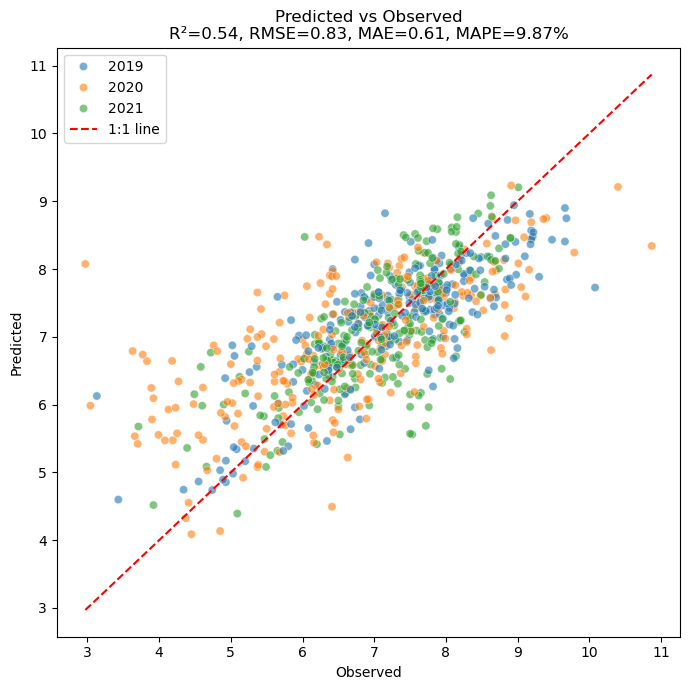

In [20]:
# Extract true and predicted values
y_true = results["target"] * test_dataset.target_std + test_dataset.target_mean
y_pred = (
    results["prediction"][:, 1] * test_dataset.target_std + test_dataset.target_mean
)

# Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Scatter plot
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_true, y=y_pred, hue=results["year"], palette="tab10", alpha=0.6)
plt.plot(
    [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 line"
)  # 1:1 line

# Labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(
    f"Predicted vs Observed\nR²={r2:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2%}"
)
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

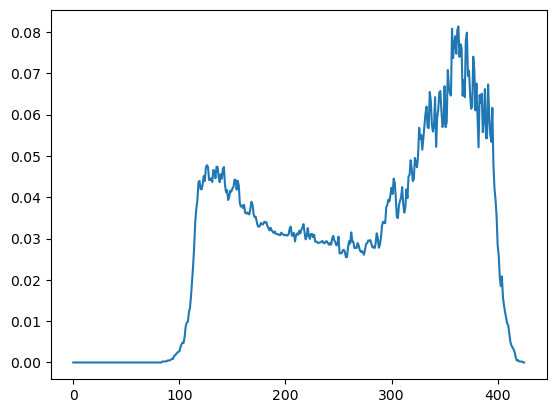

In [11]:
sns.lineplot(results["temporal_weights"].mean(axis=0)[:, 0].flatten())

<Axes: >

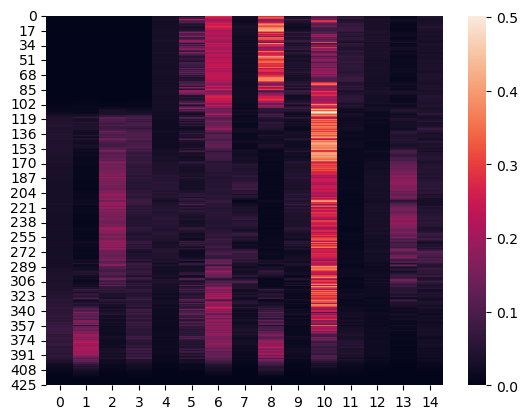

In [12]:
sns.heatmap(results["temporal_weights"].mean(axis=0)[:, :, 0])

<Axes: >

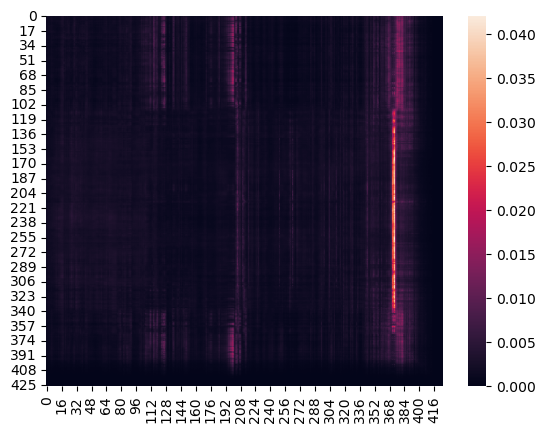

In [13]:
sns.heatmap(results["attention_weights"].mean(axis=0)[:, :])

<Axes: >

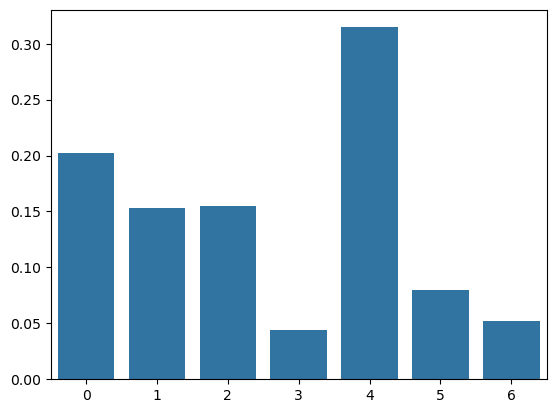

In [14]:
sns.barplot(results["static_weights"].mean(axis=0).flatten())

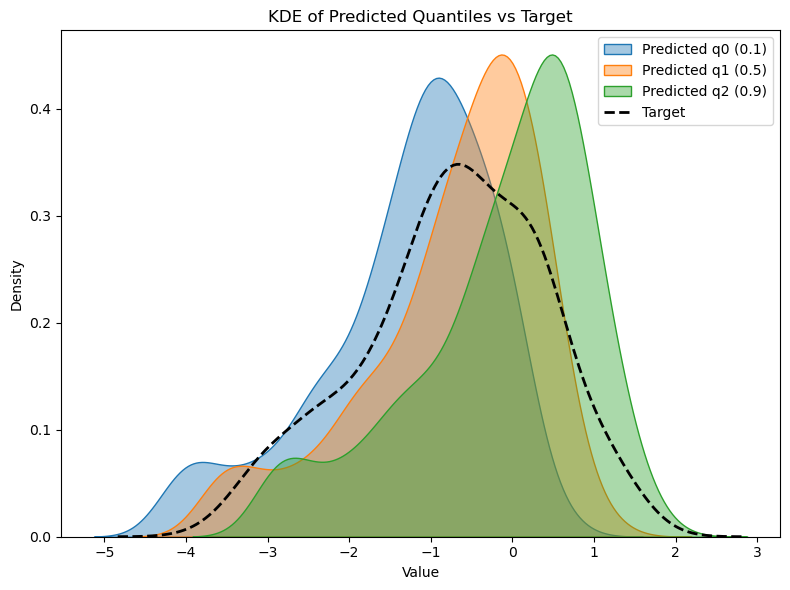

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract predicted quantiles
q0 = results["prediction"][:, 0]
q1 = results["prediction"][:, 1]
q2 = results["prediction"][:, 2]
y_true = results["target"]

plt.figure(figsize=(8, 6))

# KDE for each quantile
sns.kdeplot(q0, label="Predicted q0 (0.1)", fill=True, alpha=0.4)
sns.kdeplot(q1, label="Predicted q1 (0.5)", fill=True, alpha=0.4)
sns.kdeplot(q2, label="Predicted q2 (0.9)", fill=True, alpha=0.4)

# KDE for target
sns.kdeplot(y_true, label="Target", color="black", linestyle="--", linewidth=2)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("KDE of Predicted Quantiles vs Target")
plt.legend()
plt.tight_layout()
plt.show()

## Save the results


In [17]:
# # Save the trained model
# output_dir = os.path.join(source_folder, "train", "forecast", crop, cfg.forecast_month)
# os.makedirs(output_dir, exist_ok=True)

# model_save_path = os.path.join(output_dir, f"best_model.pt")
# torch.save(model.state_dict(), model_save_path)
# print(f"💾 Trained model saved to {model_save_path}")

# # Save outputs
# print("🔍 Evaluating and saving outputs...")

# # Evaluate and save outputs for train, validation, and test datasets
# evaluate_and_save_outputs(model, train_loader, criterion, device, output_dir, "train")
# evaluate_and_save_outputs(
#     model, val_loader, criterion, device, output_dir, "validation"
# )
# evaluate_and_save_outputs(model, test_loader, criterion, device, output_dir, "test")

# # Save the model config
# save_config(train_config, model_config, output_dir)